This all data and detail is from : 
https://www.kaggle.com/c/home-credit-default-risk/data


In [1]:
!pip install xgboost 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
import seaborn as sns
from google.colab import drive
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb



In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path  = '/content/gdrive/MyDrive/Colab data source/Home Credit risk/'
pd.set_option('display.float_format', lambda x: '%.5f' % x)
train = pd.read_csv(path+'application_train.csv')
test = pd.read_csv(path+'application_test.csv')
bureau_balance = pd.read_csv(path+'bureau_balance.csv')
POS_balance= pd.read_csv(path+'POS_CASH_balance.csv')
prev_app= pd.read_csv(path+'previous_application.csv')
credit_card_bal = pd.read_csv(path+'credit_card_balance.csv')
install_payment = pd.read_csv(path+'installments_payments.csv')
bureau  =pd.read_csv(path + 'bureau.csv')

# Explore Data & Cleaning Data

In [5]:
def showna (df ):
  print('Full frame : '+ str(len(df)))
  cnt = 0 
  for (colname , coldata) in df.iteritems():
    
    lost_percentage =  (df[colname].isna().sum()/len(df))*100
    if(lost_percentage!= 0 ):
      cnt+=1
      print(colname +' : ' +str( df[colname].isna().sum()) +' loss as : '+ str(lost_percentage)+'%')
  print("cnt lost columns : "+ str(cnt))

In [6]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,351000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.00000,-2120,NaN,1,1,0,1,1,0,Laborers,1.00000,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.02050,0.01930,0.00000,0.00000,reg oper account,block of flats,0.01490,"Stone, brick",No,2.00000,2.00000,2.00000,2.00000,-1134.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,1129500.00000,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.00000,-291,NaN,1,1,0,1,1,0,Core staff,2.00000,1,1,MONDAY,11,0,0,0,0,0,0,...,0.07870,0.05580,0.00390,0.01000,reg oper account,block of flats,0.07140,Block,No,1.00000,0.00000,1.00000,0.00000,-828.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,135000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01003,-19046,-225,-4260.00000,-2531,26.00000,1,1,1,1,1,0,Laborers,1.00000,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-815.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,297000.00000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.00802,-19005,-3039,-9833.00000,-2437,NaN,1,1,0,1,0,0,Laborers,2.00000,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00000,0.00000,2.00000,0.00000,-617.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,513000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02866,-19932,-3038,-4311.00000,-3458,NaN,1,1,0,1,0,0,Core staff,1.00000,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-1106.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [7]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307499.00000,307233.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,104582.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307509.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,134133.00000,306851.00000,246546.00000,151450.00000,127568.00000,157504.00000,103023.00000,92646.00000,143620.00000,152683.00000,154491.00000,...,152683.00000,154491.00000,98869.00000,124921.00000,97312.00000,153161.00000,93997.00000,137829.00000,159080.00000,306490.00000,306490.00000,306490.00000,306490.00000,307510.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000
mean,278180.51858,0.08073,0.41705,168797.91930,599025.99971,27108.57391,538396.20743,0.02087,-16036.99507,63815.04590,-4986.12033,-2994.20237,12.06109,1.00000,0.81989,0.19937,0.99813,0.28107,0.05672,2.15267,2.05246,2.03152,12.06342,0.01514,0.05077,0.04066,0.07817,0.23045,0.17955,0.50213,0.51439,0.51085,0.11744,0.08844,0.97773,0.75247,0.04462,0.07894,0.14972,0.22628,...,0.14921,0.22590,0.23162,0.06717,0.10195,0.10861,0.00865,0.02824,0.10255,1.42225,0.14342,1.40529,0.10005,-962.85879,0.00004,0.71002,0.00008,0.01511,0.08806,0.00019,0.08138,0.00390,0.00002,0.00391,0.00001,0.00353,0.00294,0.00121,0.00993,0.00027,0.00813,0.00060,0.00051,0.00033,0.00640,0.00700,0.03436,0.26740,0.26547,1.89997
std,102790.17535,0.27242,0.72212,237123.14628,402490.77700,14493.73732,369446.46054,0.01383,4363.98863,141275.76652,3522.88632,1509.45042,11.94481,0.00180,0.38428,0.39953,0.04316,0.44952,0.23131,0.91068,0.50903,0.50274,3.26583,0.12213,0.21953,0.19750,0.26844,0.42112,0.38382,0.21106,0.19106,0.19484,0.10824,0.08244,0.05922,0.11328,0.07604,0.13458,0.10005,0.14464,...,0.10037,0.14507,0.16193,0.08217,0.09364,0.11226,0.04741,0.07017,0.10746,2.40099,0.44670,2.37980,0.36229,826.80849,0.00650,0.45375,0.00902,0.12201,0.28338,0.01385,0.27341,0.06229,0.00477,0.06242,0.00255,0.05927,0.05411,0.03476,0.09914,0.01633,0.08980,0.02439,0.02252,0.01830,0.08385,0.11076,0.20468,0.91600,0.79406,1.86929
min,100002.00000,0.00000,0.00000,25650.00000,45000.00000,1615.50000,40500.00000,0.00029,-25229.00000,-17912.00000,-2

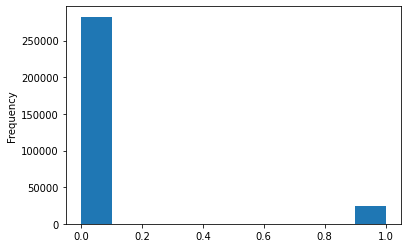

In [8]:
train['TARGET'].plot.hist()

from above graph we can see the problem we call imbalance dataset ,
 May be we have to resample it or may be try some model that great with imbalance dataset such as random forest.

In [9]:
showna(train)

Full frame : 307511
AMT_ANNUITY : 12 loss as : 0.003902299429939092%
AMT_GOODS_PRICE : 278 loss as : 0.09040327012692229%
NAME_TYPE_SUITE : 1292 loss as : 0.42014757195677555%
OWN_CAR_AGE : 202929 loss as : 65.9908100848425%
OCCUPATION_TYPE : 96391 loss as : 31.345545362604916%
CNT_FAM_MEMBERS : 2 loss as : 0.0006503832383231819%
EXT_SOURCE_1 : 173378 loss as : 56.381072546998325%
EXT_SOURCE_2 : 660 loss as : 0.21462646864665005%
EXT_SOURCE_3 : 60965 loss as : 19.825307062186393%
APARTMENTS_AVG : 156061 loss as : 50.74972927797705%
BASEMENTAREA_AVG : 179943 loss as : 58.51595552679416%
YEARS_BEGINEXPLUATATION_AVG : 150007 loss as : 48.781019215572776%
YEARS_BUILD_AVG : 204488 loss as : 66.49778381911543%
COMMONAREA_AVG : 214865 loss as : 69.87229725115525%
ELEVATORS_AVG : 163891 loss as : 53.29597965601231%
ENTRANCES_AVG : 154828 loss as : 50.3487680115508%
FLOORSMAX_AVG : 153020 loss as : 49.76082156410665%
FLOORSMIN_AVG : 208642 loss as : 67.84862980511267%
LANDAREA_AVG : 182590 loss

We saw that there a lot of null value in dataframe so  we have to deal with it we can't drop these all because there a lot of missing vaues may be we have to impute   data or  use some special ML such as XGboost that can handle these missing value but I won't decide that now let take a look for other factors .

Let's check type of each columns is if tell us something . 

In [10]:
train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [11]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [12]:
train.select_dtypes('object').apply(pd.Series.nunique,axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,351000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.00000,-2120,NaN,1,1,0,1,1,0,Laborers,1.00000,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.02050,0.01930,0.00000,0.00000,reg oper account,block of flats,0.01490,"Stone, brick",No,2.00000,2.00000,2.00000,2.00000,-1134.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,1129500.00000,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.00000,-291,NaN,1,1,0,1,1,0,Core staff,2.00000,1,1,MONDAY,11,0,0,0,0,0,0,...,0.07870,0.05580,0.00390,0.01000,reg oper account,block of flats,0.07140,Block,No,1.00000,0.00000,1.00000,0.00000,-828.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,135000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01003,-19046,-225,-4260.00000,-2531,26.00000,1,1,1,1,1,0,Laborers,1.00000,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-815.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,297000.00000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.00802,-19005,-3039,-9833.00000,-2437,NaN,1,1,0,1,0,0,Laborers,2.00000,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00000,0.00000,2.00000,0.00000,-617.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,513000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02866,-19932,-3038,-4311.00000,-3458,NaN,1,1,0,1,0,0,Core staff,1.00000,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-1106.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [14]:
train = train.replace('XNA',np.nan)
test = test.replace('XNA',np.nan)


There are a lot of category value we will have to encoding it later , due to a lot of type per  column  one-hot encoding will make it a larger dataframe but if we use label encoding it's not good because it will value one type over another without reasonable reason so I will decide to use one-hot encoding if it has too many dimension  I'll reduce dimension later  may be using PCA or other selection method.

In [15]:
print(train.shape , test.shape)
target =  train['TARGET']
train.drop(columns = 'TARGET',axis =1 ,inplace = True)
train =  pd.get_dummies(train)
test =  pd.get_dummies(test)
train , test =  train.align(test,join = 'inner',axis  =1)
train['TARGET'] =  target
print(train.shape , test.shape)



(307511, 122) (48744, 121)
(307511, 242) (48744, 241)


Let's check anomalies and outliers. 

In [16]:
train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.00000,307511.00000,307511.00000,307511.00000,307499.00000,307233.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,104582.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307509.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,134133.00000,306851.00000,246546.00000,151450.00000,127568.00000,157504.00000,103023.00000,92646.00000,143620.00000,152683.00000,154491.00000,98869.00000,...,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000
mean,278180.51858,0.41705,168797.91930,599025.99971,27108.57391,538396.20743,0.02087,-16036.99507,63815.04590,-4986.12033,-2994.20237,12.06109,1.00000,0.81989,0.19937,0.99813,0.28107,0.05672,2.15267,2.05246,2.03152,12.06342,0.01514,0.05077,0.04066,0.07817,0.23045,0.17955,0.50213,0.51439,0.51085,0.11744,0.08844,0.97773,0.75247,0.04462,0.07894,0.14972,0.22628,0.23189,...,0.00761,0.00701,0.00129,0.00028,0.00589,0.02892,0.01056,0.00642,0.12491,0.00512,0.00188,0.00113,0.00618,0.01136,0.00021,0.00016,0.00205,0.02547,0.00065,0.00717,0.00386,0.01755,0.00432,0.01849,0.01827,0.24009,0.03928,0.48942,0.00487,0.00394,0.03009,0.00747,0.00579,0.00528,0.21476,0.21077,0.01744,0.51845,0.00757,0.08073
std,102790.17535,0.72212,237123.14628,402490.77700,14493.73732,369446.46054,0.01383,4363.98863,141275.76652,3522.88632,1509.45042,11.94481,0.00180,0.38428,0.39953,0.04316,0.44952,0.23131,0.91068,0.50903,0.50274,3.26583,0.12213,0.21953,0.19750,0.26844,0.42112,0.38382,0.21106,0.19106,0.19484,0.10824,0.08244,0.05922,0.11328,0.07604,0.13458,0.10005,0.14464,0.16138,...,0.08692,0.08346

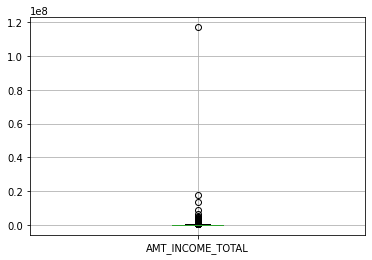

In [17]:
train.boxplot(column ='AMT_INCOME_TOTAL')

The max value is very very extreme outlier so we will drop it.

In [18]:
train  = train.drop(train[train['AMT_INCOME_TOTAL']== train['AMT_INCOME_TOTAL'].max()].index)

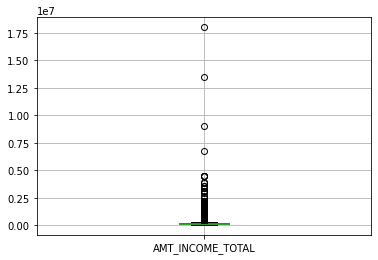

In [19]:
train.boxplot(column = 'AMT_INCOME_TOTAL')

It's look better and we will not drop other outlier because from graph it skew data . 

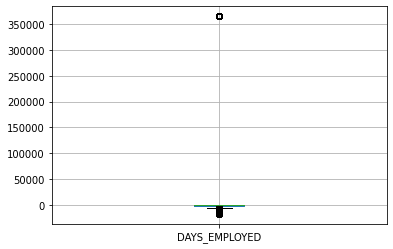

In [20]:
train.boxplot(column = 'DAYS_EMPLOYED')

The days employ should be negative (relate to application date) so this row has a chance to be anomalies data and we'll drop it. 

In [21]:
train  = train.drop(train[train['DAYS_EMPLOYED']== train['DAYS_EMPLOYED'].max()].index)


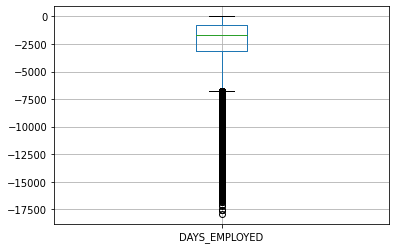

In [22]:
train.boxplot(column = 'DAYS_EMPLOYED')

In [23]:
train['Age']= train['DAYS_BIRTH']/-365
test['Age']= test['DAYS_BIRTH']/-365

In [24]:
train['Work_year'] =  train['DAYS_EMPLOYED']/-365
test['Work_year'] =  test['DAYS_EMPLOYED']/-365


My hypothesis is age  and work year has correlation with default risk let's visualize it first .

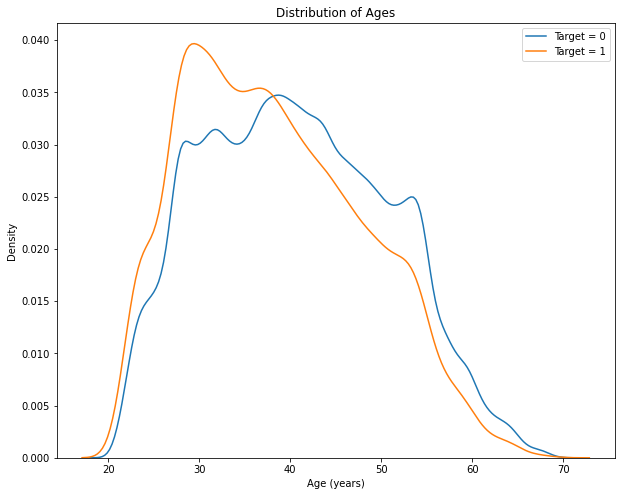

In [25]:
plt.figure(figsize=(10,8))
sns.kdeplot(train.loc[train['TARGET']==0,'Age'],label  = 'Target = 0')
sns.kdeplot(train.loc[train['TARGET']==1,'Age'],label  = 'Target = 1')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend(loc =  'upper right')

this graph show that younger age has more rate to defualt credit .
but let's go more specific which age range . 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


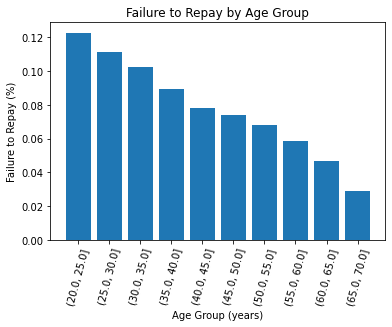

In [26]:
age_bin  = train[['TARGET','Age']]
age_bin['bin'] =  pd.cut(age_bin['Age'],bins = np.linspace(20,70,num =11))
age_bin.head()
grouped_age = age_bin.groupby('bin').mean()

plt.bar(grouped_age.index.astype(str), grouped_age['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

'Age' column may be helpful in model .  Next let's test 'Work year' 

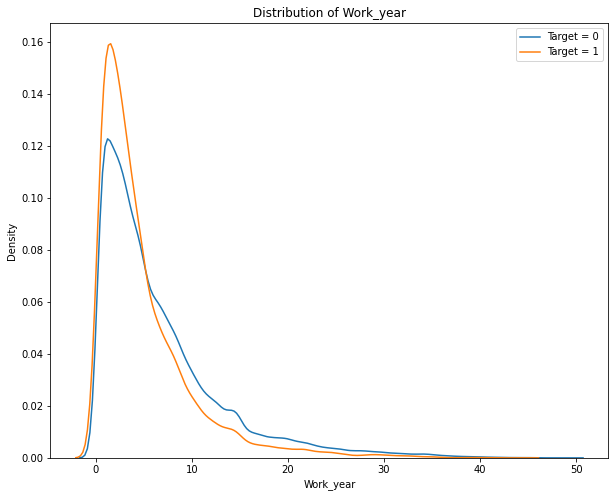

In [27]:
plt.figure(figsize=(10,8))
sns.kdeplot(train.loc[train['TARGET']==0,'Work_year'],label  = 'Target = 0')
sns.kdeplot(train.loc[train['TARGET']==1,'Work_year'],label  = 'Target = 1')
plt.xlabel('Work_year'); plt.ylabel('Density'); plt.title('Distribution of Work_year');
plt.legend(loc =  'upper right')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


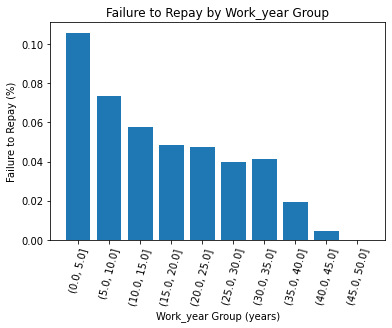

In [28]:
worked_bin  = train[['TARGET','Work_year']]
worked_bin['bin'] =  pd.cut(worked_bin['Work_year'],bins = np.linspace(0,50,num =11))
worked_bin.head()
grouped_worked = worked_bin.groupby('bin').mean()
plt.bar(grouped_worked.index.astype(str), grouped_worked['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Work_year Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Work_year Group');

This show that the less 'Work_year' the more risk to default . this features may be useful in model , keep it .

Test Correlation with Target

In [29]:
correlation = train.corr()['TARGET'].sort_values(ascending  = False,key =abs)

In [30]:
correlation.head(15)

TARGET                                               1.00000
EXT_SOURCE_3                                        -0.17974
EXT_SOURCE_2                                        -0.17051
EXT_SOURCE_1                                        -0.15535
Work_year                                           -0.07495
DAYS_EMPLOYED                                        0.07495
REGION_RATING_CLIENT_W_CITY                          0.06746
NAME_EDUCATION_TYPE_Higher education                -0.06729
Age                                                 -0.06575
DAYS_BIRTH                                           0.06575
REGION_RATING_CLIENT                                 0.06512
NAME_EDUCATION_TYPE_Secondary / secondary special    0.06063
DAYS_LAST_PHONE_CHANGE                               0.06027
AMT_GOODS_PRICE                                     -0.05034
FLOORSMAX_AVG                                       -0.04946
Name: TARGET, dtype: float64

form the correlation table there's nor strong correlation between any features and target , may be the relatoin is not a linear or may it  need additoinal features . Let's test polynomial features . 

# Features Engineering

To transform polynomialit use a lot of computatioan cost so  I will limit features up to 10  I will select top 10 by correlation.

In [31]:
features_for_poly  = correlation[1:10].index.to_list()

In [32]:
poly_features_train = train[features_for_poly]
poly_features_test = test[features_for_poly]


In [33]:
imputer = SimpleImputer(strategy = 'median') # due to we have many outlier mean is not a good choice.
poly_features_train= imputer.fit_transform(poly_features_train)
poly_features_test= imputer.fit_transform(poly_features_test)


In [34]:
transformer =  PolynomialFeatures(degree= 3)
transformer.fit(poly_features_train)
poly_features_train = transformer.transform(poly_features_train)
poly_features_test = transformer.transform(poly_features_test)


In [35]:
target = train['TARGET'].copy()
target.isna().sum()

0

In [36]:
#debug
len(target)

252136

In [37]:
# convert these to data frame 
poly_features_train  =  pd.DataFrame(poly_features_train, columns = transformer.get_feature_names(input_features=features_for_poly))
poly_features_train['TARGET'] = target

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
poly_corr = poly_features_train.corr()['TARGET'].sort_values(ascending  = False,key =abs)
poly_corr.head(15)

TARGET                                                   1.00000
EXT_SOURCE_3 EXT_SOURCE_1                                0.00377
EXT_SOURCE_3 EXT_SOURCE_1 Age                            0.00366
EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH                    -0.00366
EXT_SOURCE_3^2 EXT_SOURCE_1                              0.00346
EXT_SOURCE_3 DAYS_BIRTH^2                                0.00333
EXT_SOURCE_3 Age DAYS_BIRTH                             -0.00333
EXT_SOURCE_3 Age^2                                       0.00333
EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY    0.00331
EXT_SOURCE_3 Age                                         0.00326
EXT_SOURCE_3 DAYS_BIRTH                                 -0.00326
EXT_SOURCE_3 EXT_SOURCE_1^2                              0.00316
Work_year REGION_RATING_CLIENT_W_CITY^2                 -0.00310
DAYS_EMPLOYED REGION_RATING_CLIENT_W_CITY^2              0.00310
EXT_SOURCE_3 EXT_SOURCE_2 EXT_SOURCE_1                   0.00296
Name: TARGET, dtype: floa

The polynomial is still not a good choice for this  may be Domain knowledge feautre may help .

Disclaimer : I'm not financial expertist so  new features I create is from researching form internet and some common senses.

Some factors that may have effect . 
- existing dept 
-previous payment history 
- Colleteral 


In [39]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [40]:
bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

Metadata :Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD(days past due), 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )

And from this we get feature previous payment history that how their behaviral in payment late or ontime .

Let's take 'Close' and 'Unknown' as 0 because we don't want to make their payment history dirty without evidence.

In [41]:
late_score = bureau_balance[['SK_ID_BUREAU','STATUS']]
late_score['STATUS'].replace({'C':'0' ,'X':'0'},inplace=True)
late_score['STATUS']  = late_score['STATUS'].astype(int)
late_score['STATUS'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    26956982
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [42]:
select_bureau  = bureau[['SK_ID_BUREAU','SK_ID_CURR','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE']]
select_bureau.head()


,SK_ID_BUREAU,SK_ID_CURR,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
0,5714462,215354,0.00000,NaN,0.00000
1,5714463,215354,171342.00000,NaN,0.00000
2,5714464,215354,NaN,NaN,0.00000
3,5714465,215354,NaN,NaN,0.00000
4,5714466,215354,NaN,NaN,0.00000


In [43]:
showna(select_bureau)

Full frame : 1716428
AMT_CREDIT_SUM_DEBT : 257669 loss as : 15.011931755948982%
AMT_CREDIT_SUM_LIMIT : 591780 loss as : 34.47741472406649%
cnt lost columns : 2


In [44]:
select_bureau.describe()

,SK_ID_BUREAU,SK_ID_CURR,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
count,1716428.00000,1716428.00000,1458759.00000,1124648.00000,1716428.00000
mean,5924434.48903,278214.93364,137085.11995,6229.51498,37.91276
std,532265.72855,102938.55811,677401.13095,45032.03148,5937.65003
min,5000000.00000,100001.00000,-4705600.32000,-586406.11500,0.00000
25%,5463953.75000,188866.75000,0.00000,0.00000,0.00000
50%,5926303.50000,278055.00000,0.00000,0.00000,0.00000
75%,6385681.25000,367426.00000,40153.50000,0.00000,0.00000
max,6843457.00000,456255.00000,170100000.00000,4705600.32000,3756681.00000


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


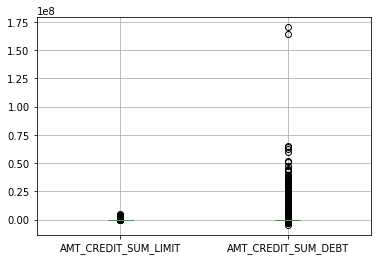

In [45]:
select_bureau.boxplot(column = ['AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_DEBT'] )

we saw the anomalies in amount credit sum debt and amount credit limit it shouldn't be negative and we will drop extreme outlier after we merge into trainset.

In [46]:
select_bureau['AMT_CREDIT_SUM_DEBT'].apply(lambda x : max(0,x))
select_bureau['AMT_CREDIT_SUM_LIMIT'].apply(lambda x : max(0,x))



0         0.00000
1         0.00000
2         0.00000
3         0.00000
4         0.00000
            ...  
1716423   0.00000
1716424   0.00000
1716425   0.00000
1716426   0.00000
1716427   0.00000
Name: AMT_CREDIT_SUM_LIMIT, Length: 1716428, dtype: float64

In [47]:
late_score.shape
print(late_score.columns)

Index(['SK_ID_BUREAU', 'STATUS'], dtype='object')


In [48]:
select_bureau.head()
print(len(select_bureau))

1716428


In [49]:

select_bureau = select_bureau.merge(late_score.drop_duplicates(subset=['SK_ID_BUREAU']),how = 'left',on  = 'SK_ID_BUREAU')
print(len(select_bureau))
select_bureau.head()


1716428


,SK_ID_BUREAU,SK_ID_CURR,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,STATUS
0,5714462,215354,0.00000,NaN,0.00000,NaN
1,5714463,215354,171342.00000,NaN,0.00000,NaN
2,5714464,215354,NaN,NaN,0.00000,NaN
3,5714465,215354,NaN,NaN,0.00000,NaN
4,5714466,215354,NaN,NaN,0.00000,NaN


In [50]:
select_bureau.rename(columns= {'STATUS': 'late_score'},inplace = True)
select_bureau.head()

,SK_ID_BUREAU,SK_ID_CURR,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,late_score
0,5714462,215354,0.00000,NaN,0.00000,NaN
1,5714463,215354,171342.00000,NaN,0.00000,NaN
2,5714464,215354,NaN,NaN,0.00000,NaN
3,5714465,215354,NaN,NaN,0.00000,NaN
4,5714466,215354,NaN,NaN,0.00000,NaN


In [51]:
showna(select_bureau)

Full frame : 1716428
AMT_CREDIT_SUM_DEBT : 257669 loss as : 15.011931755948982%
AMT_CREDIT_SUM_LIMIT : 591780 loss as : 34.47741472406649%
late_score : 942074 loss as : 54.885727802156566%
cnt lost columns : 3


In [52]:
select_bureau['late_score'] =  select_bureau['late_score'].fillna(0)
select_bureau=select_bureau.fillna(select_bureau.median())

showna(select_bureau)

Full frame : 1716428
cnt lost columns : 0


In [53]:
credit_card_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97000,135000,0.00000,877.50000,0.00000,877.50000,1700.32500,1800.00000,1800.00000,0.00000,0.00000,0.00000,0.00000,1,0.00000,1.00000,35.00000,Active,0,0
1,2582071,363914,-1,63975.55500,45000,2250.00000,2250.00000,0.00000,0.00000,2250.00000,2250.00000,2250.00000,60175.08000,64875.55500,64875.55500,1.00000,1,0.00000,0.00000,69.00000,Active,0,0
2,1740877,371185,-7,31815.22500,450000,0.00000,0.00000,0.00000,0.00000,2250.00000,2250.00000,2250.00000,26926.42500,31460.08500,31460.08500,0.00000,0,0.00000,0.00000,30.00000,Active,0,0
3,1389973,337855,-4,236572.11000,225000,2250.00000,2250.00000,0.00000,0.00000,11795.76000,11925.00000,11925.00000,224949.28500,233048.97000,233048.97000,1.00000,1,0.00000,0.00000,10.00000,Active,0,0
4,1891521,126868,-1,453919.45500,450000,0.00000,11547.00000,0.00000,11547.00000,22924.89000,27000.00000,27000.00000,443044.39500,453919.45500,453919.45500,0.00000,1,0.00000,1.00000,101.00000,Active,0,0


Metadata  
AMT_BALANCE : Balance during the month of previous credit

In [54]:
credit_card_bal['AMT_BALANCE'].describe()

count   3840312.00000
mean      58300.15526
std      106307.03102
min     -420250.18500
25%           0.00000
50%           0.00000
75%       89046.68625
max     1505902.18500
Name: AMT_BALANCE, dtype: float64

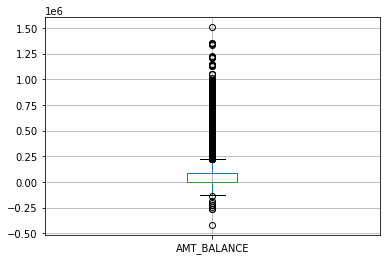

In [55]:
credit_card_bal.boxplot(column  = 'AMT_BALANCE')

In [56]:
select_bureau = select_bureau.merge(credit_card_bal[['AMT_BALANCE','SK_ID_CURR']].drop_duplicates(subset=['SK_ID_CURR']),how = 'left',on = 'SK_ID_CURR')
select_bureau.head()

,SK_ID_BUREAU,SK_ID_CURR,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,late_score,AMT_BALANCE
0,5714462,215354,0.00000,0.00000,0.00000,0.00000,424505.02500
1,5714463,215354,171342.00000,0.00000,0.00000,0.00000,424505.02500
2,5714464,215354,0.00000,0.00000,0.00000,0.00000,424505.02500
3,5714465,215354,0.00000,0.00000,0.00000,0.00000,424505.02500
4,5714466,215354,0.00000,0.00000,0.00000,0.00000,424505.02500


In [57]:
select_bureau = select_bureau.fillna(select_bureau.median())
showna(select_bureau)

Full frame : 1716428
cnt lost columns : 0


in part of colleteral we will use columns ['FLAG_OWN_CAR','FLAG_OWN_REALTY'] it's already in train  -test 

I'll use these that were inspired by [this script](https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993) by Aguiar:


-CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income

-ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income

-CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due

-DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [58]:
def createDomainFeatures (app_train_domain):
  app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
  app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
  app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
  app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
  return app_train_domain

In [59]:
train = createDomainFeatures(train)
test =  createDomainFeatures(test)


In [60]:
train  = train.merge(select_bureau.drop_duplicates(subset=['SK_ID_CURR']), how =  'left',on ='SK_ID_CURR' )
test  = test.merge(select_bureau.drop_duplicates(subset=['SK_ID_CURR']), how =  'left',on ='SK_ID_CURR' )


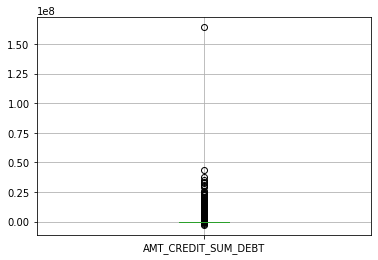

In [61]:
train.boxplot(column = 'AMT_CREDIT_SUM_DEBT')

In [62]:
print(len(target), len(train))

252136 252136


In [63]:
train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,Age,Work_year,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,SK_ID_BUREAU,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,late_score,AMT_BALANCE
count,252136.00000,252136.00000,252136.00000,252136.00000,252124.00000,251880.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,94413.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252134.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,121275.00000,251632.00000,202240.00000,124800.00000,105123.00000,129795.00000,84757.00000,76250.00000,118358.00000,125786.00000,127279.00000,81339.00000,...,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252136.00000,252124.00000,252124.00000,252136.00000,216476.00000,216476.00000,216476.00000,216476.00000,216476.00000,216476.00000
mean,278115.29016,0.49851,175450.73321,611398.65156,27812.33158,549406.04498,0.02089,-14769.14172,-2384.17512,-4635.42242,-2800.63638,11.95019,1.00000,0.99995,0.24315,0.99787,0.27768,0.06350,2.25252,2.04461,2.02333,12.20330,0.01724,0.06192,0.04959,0.08977,0.28107,0.21899,0.48191,0.51614,0.50034,0.11826,0.08849,0.97750,0.75278,0.04506,0.07956,0.14953,0.22735,0.23309,...,0.00754,0.01385,0.00025,0.00019,0.00250,0.03106,0.00080,0.00874,0.00471,0.02141,0.00526,0.01889,0.01838,0.24089,0.03934,0.49156,0.00530,0.00399,0.02979,0.00761,0.00603,0.00539,0.21551,0.21194,0.01762,0.52091,0.00772,0.08660,40.46340,6.53199,3.85801,0.17727,0.05389,0.15686,5893468.64875,113161.40935,2818.93600,37.12698,0.00736,21291.96529
std,102815.32582,0.76316,113468.01638,406527.99438,14647.78780,373269.22765,0.01387,3662.57852,2338.36299,3252.17285,1515.36271,11.98195,0.00199,0.00690,0.42899,0.04606,0.44786,0.24386,0.94212,0.51239,0.50642,3.29980,0.13017,0.24101,0.21709,0.28585,0.44952,0.41356,0.20550,0.18992,0.19600,0.10922,0.08237,0.06110,0.11456,0.07711,0.13526,0.10058,0.14550,0.16217,...,0.08648,0.11687,0.01593,0.01394,0.04996,0.17348,0.02822,0.09309,0.06845,0.14474,0.07236,0.13615,0.13433,0.42762,0.19440,0.49993,0.07263,0.06307,0

In [64]:

# print(target.isna().sum())
# train['TARGET'] = target
print(train['TARGET'].isna().sum())
train.drop(train[train['AMT_CREDIT_SUM_DEBT']== train['AMT_CREDIT_SUM_DEBT'].max()].index,axis= 0 ,inplace =  True)
target = train['TARGET']
print(train['TARGET'].isna().sum())
train.drop(columns = 'TARGET',inplace = True)


0
0


In [65]:
train =  train.fillna(train.median())
test =  test.fillna(test.median())


Features Selection

In [66]:
# !pip install git+https://github.com/AutoViML/featurewiz.git
#  df = train.copy()
#  msk = np.random.rand(len(df)) < 0.8
#  train1 = df[msk]
#  train2 = df[~msk]
#  from featurewiz import featurewiz
# a,b = featurewiz(train1, target='TARGET', corr_limit=0.70,  verbose=0,test_data= train2)


In [67]:
train_feat =  train.columns.to_list()
X = train[train_feat]
Y = target 
print(len(X), len(Y))

252135 252135


In [68]:
train_feat =  train.columns.to_list()
X = train[train_feat]
Y = target 
ExtraT = ExtraTreesClassifier()
ExtraT.fit(X,Y)
print(ExtraT.feature_importances_)

[1.41307401e-02 9.95644179e-03 1.37263517e-02 1.33717896e-02
 1.34641154e-02 1.31527134e-02 1.36538319e-02 1.46521571e-02
 1.40244477e-02 1.42262980e-02 1.46998307e-02 7.02669269e-03
 0.00000000e+00 2.22670640e-05 8.18960359e-03 4.08426977e-04
 7.50332840e-03 4.00175347e-03 1.07816868e-02 6.00735366e-03
 6.06991144e-03 1.39336651e-02 1.50116035e-03 3.14838637e-03
 2.75798659e-03 4.43662182e-03 5.80884271e-03 6.04163339e-03
 1.45719714e-02 2.79129487e-02 2.66091113e-02 4.58275834e-03
 4.32139526e-03 5.14309559e-03 4.04554615e-03 3.86130013e-03
 2.30752094e-03 4.45663772e-03 3.67234047e-03 3.13058532e-03
 4.57095595e-03 3.72423853e-03 4.70936003e-03 2.81758838e-03
 4.47601475e-03 4.47443475e-03 4.34336979e-03 5.21725928e-03
 4.13906517e-03 3.84181507e-03 2.17252243e-03 4.35347242e-03
 3.64022166e-03 3.09804932e-03 4.59457564e-03 3.76660868e-03
 4.81201112e-03 2.61251403e-03 4.25835739e-03 4.59390166e-03
 4.38113616e-03 5.26258630e-03 4.02900325e-03 3.83337976e-03
 2.18205880e-03 4.386042

In [69]:
features_imp_df = pd.DataFrame({'features':train_feat,'importance':ExtraT.feature_importances_})

In [70]:
  features_imp_df.sort_values(ascending =  False , inplace = True,by  = 'importance')
  features_imp_df.reset_index(drop= True,inplace= True)
  features_imp_df.head(30)

,features,importance
0,EXT_SOURCE_2,0.02791
1,EXT_SOURCE_3,0.02661
2,Age,0.01474
3,DAYS_ID_PUBLISH,0.01470
4,DAYS_BIRTH,0.01465
5,EXT_SOURCE_1,0.01457
6,DAYS_LAST_PHONE_CHANGE,0.01446
7,DAYS_EMPLOYED_PERCENT,0.01432
8,ANNUITY_INCOME_PERCENT,0.01423
9,DAYS_REGISTRATION,0.01423


I will drop some unreasonable features and redundant one .

In [71]:
top_imp = features_imp_df[features_imp_df['importance']>=0.01]
selected_feat =  top_imp['features'].to_list()
print(selected_feat)

['EXT_SOURCE_2', 'EXT_SOURCE_3', 'Age', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED_PERCENT', 'ANNUITY_INCOME_PERCENT', 'DAYS_REGISTRATION', 'SK_ID_CURR', 'Work_year', 'DAYS_EMPLOYED', 'HOUR_APPR_PROCESS_START', 'CREDIT_INCOME_PERCENT', 'AMT_INCOME_TOTAL', 'CREDIT_TERM', 'REGION_POPULATION_RELATIVE', 'SK_ID_BUREAU', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS']


In [72]:
to_drop =  ['SK_ID_BUREAU','SK_ID_CURR','DAYS_BIRTH','Work_year'] #DAYS_BIRTH and Work_year is redundant and SK_ID don't make sense.
selected_feat =  list(set(selected_feat).difference(set(to_drop)))
print(selected_feat)

['DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED_PERCENT', 'HOUR_APPR_PROCESS_START', 'AMT_CREDIT', 'ANNUITY_INCOME_PERCENT', 'REGION_POPULATION_RELATIVE', 'CREDIT_TERM', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CREDIT_INCOME_PERCENT', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'Age', 'EXT_SOURCE_1', 'AMT_REQ_CREDIT_BUREAU_YEAR']





# Data Preparation

In [73]:
X_train  ,X_val   , y_train,y_val = train_test_split(train[selected_feat], target ,test_size= 0.2 , random_state= 42)
print(X_train.shape , y_train.shape)
print(X_val.shape , y_val.shape)

(201708, 22) (201708,)
(50427, 22) (50427,)


In [74]:
scaler  = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Train Model 

In [75]:
xgb_cl =  xgb.XGBRFClassifier()
xgb_cl.fit(X_train, y_train)
y_hat_xgb =  xgb_cl.predict(X_val)

In [89]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)
ans =  log_reg.predict(X_val)

In [91]:
unique, counts = np.unique(ans, return_counts=True)

print (np.asarray((unique, counts)).T)

[[    0 50427]]


In [99]:
from sklearn.metrics import accuracy_score
accuracy_score(y_hat_xgb, y_val)

0.9143316080671069

# Evaluate

# Submission